# dSprites - Disentanglement testing Sprites dataset

## Description
Procedurally generated 2D shapes dataset. This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite (color isn't varying here, its value is fixed).

All possible combinations of the latents are present.

The ordering of images in the dataset (i.e. shape[0] in all ndarrays) is fixed and meaningful, see below.

We chose the smallest changes in latent values that generated different pixel outputs at our 64x64 resolution after rasterization.

No noise added, single image sample for a given latent setting.

## Details about the ordering of the dataset

Latent dim meanings: ('color', 'shape', 'scale', 'orientation', 'posX', 'posY')

The dataset was generated procedurally, and its order is deterministic.
For example, the image at index 0 corresponds to the latents (0, 0, 0, 0, 0, 0).

Then the image at index 1 increases the least significant "bit" of the latent:
(0, 0, 0, 0, 0, 1)

And similarly, till we reach index 32, where we get (0, 0, 0, 0, 1, 0). 

Hence the dataset is sequentially addressable using variable bases for every "bit".
Using dataset['metadata']['latents_sizes'] makes this conversion trivial, see below.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import os

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})


In [2]:
# Load dataset
print(os.getcwd())
dataset_zip = np.load('./datasets/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', allow_pickle=True, encoding='latin1')

print('Keys in the dataset:', dataset_zip.keys())
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]

print('Metadata: \n', metadata)
print(latents_classes)

# Define number of values per latents and functions to convert to indices
latents_sizes = metadata['latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

print(latents_bases)
print(latents_sizes)


/home/c01muya/vae-disentanglement
Keys in the dataset: KeysView(<numpy.lib.npyio.NpzFile object at 0x7fab54b81790>)
Metadata: 
 {'date': 'April 2017', 'description': 'Disentanglement test Sprites dataset.Procedurally generated 2D shapes, from 6 disentangled latent factors.This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite. All possible variations of the latents are present. Ordering along dimension 1 is fixed and can be mapped back to the exact latent values that generated that image.We made sure that the pixel outputs are different. No noise added.', 'version': 1, 'latents_names': ('color', 'shape', 'scale', 'orientation', 'posX', 'posY'), 'latents_possible_values': {'orientation': array([0.        , 0.16110732, 0.32221463, 0.48332195, 0.64442926,
       0.80553658, 0.96664389, 1.12775121, 1.28885852, 1.44996584,
       1.61107316, 1.77218047, 1.93328779, 2.0943951 , 2.25550242,
       2.41660973, 2.57771705, 2.73882436, 2.89993168, 3.0

In [20]:
# Sample latents randomly
latents_sampled = sample_latent(size=23040*2)

# Select images
latents_sampled[:, -2] = 20
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

np.savez_compressed(
    "/home/c01muya/vae-disentanglement/datasets/dsprites_cond/dsprites_ndarray_co1sh3sc6or40x1y32_64x64.npz",
    imgs=imgs_sampled,
    latents_values=latents_sampled,
    latents_classes=latents_classes,
    metadata=metadata
)

In [2]:
cd /home/c01muya/vae-disentanglement/disentanglement_lib_pl

/home/c01muya/vae-disentanglement/disentanglement_lib_pl


In [3]:
from common.data_loader import DSpritesDataset, ThreeShapesDataset, ContinumDataset
import torch
import torchvision.utils as vutils
import torchvision.transforms.functional as T
from torch.utils.data import DataLoader
from torchvision import transforms


dataset = DSpritesDataset(root="../datasets/dsprites/", split="train", transforms=transforms.ToTensor(),
                         correlated=False, conditioned=True)


Loading conditioned dataset
Loaded 46080 images


In [4]:
loader = DataLoader(dataset, batch_size=16, shuffle = True, drop_last=True)

I,L = next(loader.__iter__())
print(I.shape)
print(L.shape)

torch.Size([1, 64, 64])
(6,)
torch.Size([1, 64, 64])
(6,)
torch.Size([1, 64, 64])
(6,)
torch.Size([1, 64, 64])
(6,)
torch.Size([1, 64, 64])
(6,)
torch.Size([1, 64, 64])
(6,)
torch.Size([1, 64, 64])
(6,)
torch.Size([1, 64, 64])
(6,)
torch.Size([1, 64, 64])
(6,)
torch.Size([1, 64, 64])
(6,)
torch.Size([1, 64, 64])
(6,)
torch.Size([1, 64, 64])
(6,)
torch.Size([1, 64, 64])
(6,)
torch.Size([1, 64, 64])
(6,)
torch.Size([1, 64, 64])
(6,)
torch.Size([1, 64, 64])
(6,)
torch.Size([16, 1, 64, 64])
torch.Size([16, 6])


In [3]:
COLOR=0
ORIENTATION=3

def latent_to_index(latents):
    
    # when indexing we have to fix color because of how they generated 
    # the dataset
    latents[:,0] = np.zeros(len(latents)) 
    return np.dot(latents, latents_bases).astype(int)


def sample_latent(size=1, correlated=False, in_idx=None, out_idx=None, map_fn=None):
    samples = np.zeros((size, latents_sizes.size))
    for lat_i, lat_size in enumerate(latents_sizes):
        samples[:, lat_i] = np.random.randint(lat_size, size=size)

    if correlated:
        samples[:, out_idx] = map_fn(samples[:,in_idx])
    
    return samples


In [4]:
from matplotlib import cm

# Helper function to show images
def show_images_grid(imgs_, num_images=25):
    ncols = int(np.ceil(num_images**0.5))
    nrows = int(np.ceil(num_images / ncols))
    _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
    axes = axes.flatten()

    norm = cm.colors.Normalize(vmax=1.0, vmin=0.0)
    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            ax.imshow(imgs_[ax_i], cmap='gray',  norm=norm)#, interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
    else:
        ax.axis('off')

def show_density(imgs):
    _, ax = plt.subplots()
    ax.imshow(imgs.mean(axis=0), interpolation='nearest', cmap='Greys_r')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

## Randomly sampling into the dataset

In [ ]:
# Sample latents randomly
latents_sampled = sample_latent(size=5000)

# Select images
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

# Show images
#show_images_grid(imgs_sampled)

# Compute the density of the data to show that no pixel ever goes out of
# the boundary. Obviously it also means that the main support of the pixels is in the center
# half. 
# Locations cover a square, which make the aligned X-Y latents more likely for
# models to discover.

#show_density(imgs_sampled)

## Conditional sampling of the dataset

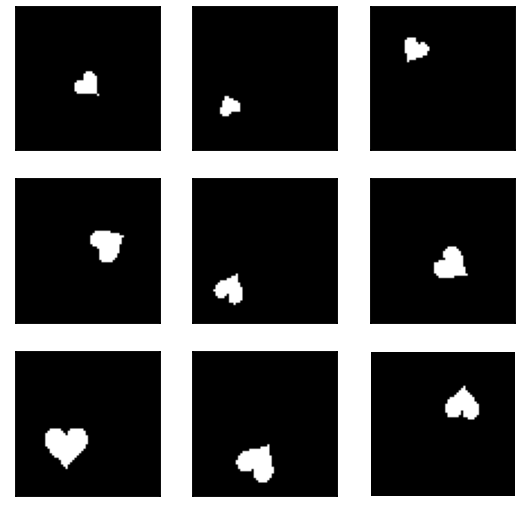

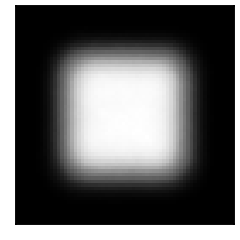

In [10]:
latents_sampled = sample_latent(size=23040*2)
## Fix posX (2nd last coord in latent z) to left(=0)
latents_sampled[:, 1] = 2
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

# Samples
show_images_grid(imgs_sampled, 9)

# Show the density too to check
show_density(imgs_sampled)

In [ ]:
## Fix orientation to 0.8 rad
latents_sampled = sample_latent(size=5000)
latents_sampled[:, 3] = 5
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

# Samples
show_images_grid(imgs_sampled, 9)

# Density should not be different than for all orientations
show_density(imgs_sampled)

In [8]:
from tqdm import tqdm

def create_correlated_data():
    
    dataset_zip = np.load('./datasets/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', 
                          allow_pickle=True, encoding='latin1')
    imgs = dataset_zip['imgs']
    mod_images = np.zeros_like(imgs, dtype=np.float32)
    
    latents_values = dataset_zip['latents_values']
    latents_classes = dataset_zip['latents_classes']
    metadata = dataset_zip['metadata'][()]
    ORIENTATION = 3
    orientation_values = metadata['latents_possible_values']['orientation']
    
    ONE_TWENTY_DEG, TWO_FORTY_DEG = orientation_values[13], orientation_values[26] #2.0943951, 4.1887902
    COLOR = 0
    
    # go thru all the images and alter the color depending on the value of rotation
    
    hist = {
        'a':0,'b':0,'c':0
    }
    
    for i, latent_value in tqdm(enumerate(latents_values)):
        
        #print(latent_value[ORIENTATION])
        
        # Compare orientation and depending on the value dim the image brightness
        if latent_value[ORIENTATION] >= 0 and latent_value[ORIENTATION] <= ONE_TWENTY_DEG:
            
            latents_values[i][COLOR] = 1
            latents_classes[i][COLOR] = 1
            mod_images[i] = imgs[i] * 0.50
            hist['a'] += 1
        
        elif latent_value[ORIENTATION] > ONE_TWENTY_DEG and latent_value[ORIENTATION] <= TWO_FORTY_DEG:
            
            latents_values[i][COLOR] = 2
            latents_classes[i][COLOR] = 2
            mod_images[i] = imgs[i] * 0.75
            hist['b'] += 1
        
        else: 
            
            # If greater than 120 degrees, then no modification
            mod_images[i] = imgs[i]
            hist['c'] += 1
        
    return hist, mod_images, latents_values, latents_classes

def create_3dcorrelated_data():
    
    dataset_zip = np.load('./datasets/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', allow_pickle=True, encoding='latin1')
    imgs = dataset_zip['imgs']
    mod_images = np.zeros(shape=(737280,64,64,3), dtype=np.float32)
    
    latents_values = dataset_zip['latents_values']
    latents_classes = dataset_zip['latents_classes']
    metadata = dataset_zip['metadata'][()]
    ORIENTATION = 3
    orientation_values = metadata['latents_possible_values']['orientation']
    
    ONE_TWENTY_DEG, TWO_FORTY_DEG = orientation_values[13], orientation_values[26] #2.0943951, 4.1887902
    COLOR = 0
    
    # go thru all the images and alter the color depending on the value of rotation
    
    hist = {
        'a':0,'b':0,'c':0
    }
    
    for i, latent_value in tqdm(enumerate(latents_values)):
        
        #print(latent_value[ORIENTATION])
        
        # Compare orientation and depending on the value dim the image brightness
        if latent_value[ORIENTATION] >= 0 and latent_value[ORIENTATION] <= ONE_TWENTY_DEG:
            
            latents_values[i][COLOR] = 1
            latents_classes[i][COLOR] = 1
            mod_images[i] = np.stack([imgs[i] * 0.50, imgs[i], imgs[i]], axis=2)
            hist['a'] += 1
        
        elif latent_value[ORIENTATION] > ONE_TWENTY_DEG and latent_value[ORIENTATION] <= TWO_FORTY_DEG:
            
            latents_values[i][COLOR] = 2
            latents_classes[i][COLOR] = 2
            mod_images[i] = np.stack([imgs[i], imgs[i] * 0.50, imgs[i]], axis=2)
            hist['b'] += 1
        
        else: 
            
            # If greater than 120 degrees,
            mod_images[i] = np.stack([imgs[i], imgs[i], imgs[i]*0.50], axis=2)
            hist['c'] += 1
        
    return hist, mod_images, latents_values, latents_classes


In [16]:
mod_imgs.shape

(737280, 64, 64, 3)

In [10]:
h, mod_imgs, mod_latents_values, mod_latents_classes = create_3dcorrelated_data()

737280it [00:24, 30205.84it/s]


In [11]:
#from matplotlib import cm
#norm = cm.colors.Normalize(vmax=1.0, vmin=0.0)
#plt.imshow(imgs[0],cmap='gray', norm=norm)
print(h)
#print(0,2*np.pi/3)
#print(2*np.pi/3,(4*np.pi)/3)
#print(4*np.pi/3,2*np.pi)

{'a': 258048, 'b': 239616, 'c': 239616}


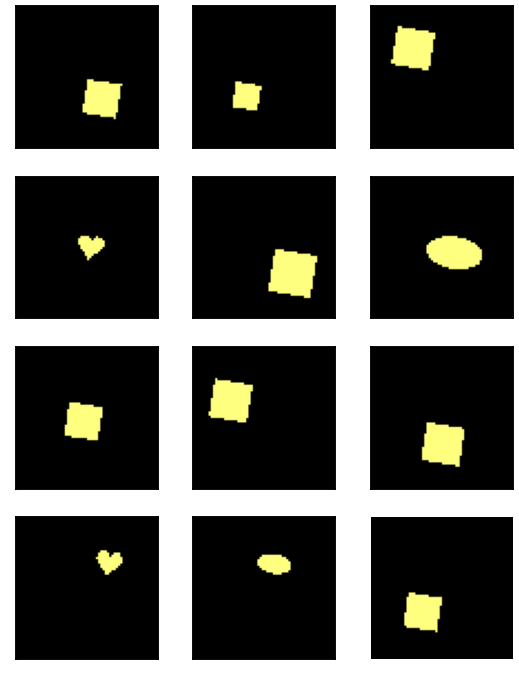

In [15]:
# {'orientation': array([

# DIMMEST (0 to 120deg)
#        0.        , 0.16110732, 0.32221463, 0.48332195, 0.64442926,
#        0.80553658, 0.96664389, 1.12775121, 1.28885852, 1.44996584,
#        1.61107316, 1.77218047, 1.93328779, 2.0943951 , 

# DiM (120deg to 240deg)
#        2.25550242,
#        2.41660973, 2.57771705, 2.73882436, 2.89993168, 3.061039  ,
#        3.22214631, 3.38325363, 3.54436094, 3.70546826, 3.86657557,
#        4.02768289, 4.1887902 , 

# WHITE (240deg to 360deg)
#        4.34989752, 4.51100484, 4.67211215,
#        4.83321947, 4.99432678, 5.1554341 , 5.31654141, 5.47764873,
#        5.63875604, 5.79986336, 5.96097068, 6.12207799, 6.28318531])}

# 0.0 2.0943951023931957
# 2.2555024179619028 4.188790204786391
# 4.349897520355098 6.283185307179586

latents_sampled = sample_latent(size=12)
latents_sampled[:, 3] =  38 # choose from: 5, 20 , 35
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled_0 = mod_imgs[indices_sampled]
show_images_grid(imgs_sampled_0, 12)

In [17]:
#Save the data back

COLOR = 0
metadata['latents_sizes'][COLOR] = 3

np.savez_compressed(
    "./datasets/dsprites/dsprites_ndarray_co3sh3sc6or40x32y32_64x64x3.npz",
    imgs=mod_imgs,
    latents_values=mod_latents_values,
    latents_classes=mod_latents_classes,
    metadata=metadata
)

In [ ]:
# Load dataset again to test 

dataset_zip = np.load('dsprites_ndarray_co3sh3sc6or40x32y32_64x64.npz', allow_pickle=True)

print('Keys in the dataset:', dataset_zip.keys())
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]

print('Metadata: \n', metadata)
print(latents_classes)

# Define number of values per latents and functions to convert to indices
latents_sizes = metadata['latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:], np.array([1,])))

print(latents_sizes)
print(latents_bases)

In [ ]:

FULL_BRIGHTNESS_RANGE = range(0,14)
FIFTY_PCT_BRIGHTNESS_RANGE = range(14,27)
SEVENTY_FIVE_PCT_BRIGHTNESS_RANGE = range(27,40)

def map_fn(orientation_values):
    
    def get_color_from_orientation(orientation):
        
        FIFTY_PCT_BRIGHTNESS_RANGE = range(0,14)
        SEVENTY_FIVE_PCT_BRIGHTNESS_RANGE = range(14,27)
        FULL_BRIGHTNESS_RANGE = range(27,40)

        if orientation in FULL_BRIGHTNESS_RANGE:
            return 0
        if orientation in FIFTY_PCT_BRIGHTNESS_RANGE:
            return 1
        if orientation in SEVENTY_FIVE_PCT_BRIGHTNESS_RANGE:
            return 2
        raise NotImplemented()
        
    return np.vectorize(get_color_from_orientation)(orientation_values)



In [ ]:
# Sample latents randomly
latents_sampled = sample_latent(size=16,correlated=True, 
                                in_idx=ORIENTATION, out_idx=COLOR, map_fn=map_fn)
print(latents_sampled)
# Select images
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]
# Show images
show_images_grid(imgs_sampled, 16)

In [ ]:
# Sample latents randomly
latents_sampled = sample_latent(size=16,correlated=True, 
                                in_idx=ORIENTATION, out_idx=COLOR, map_fn=map_fn)
print(latents_sampled)
# Select images
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]
# Show images
show_images_grid(imgs_sampled, 16)

In [ ]:
print(latents_sampled[:,COLOR])
print(latents_sampled[:,ORIENTATION])

latents_sampled[:,COLOR] = map_fn(latents_sampled[:,ORIENTATION])

print(latents_sampled[:,COLOR])
print(map_fn(latents_sampled[:,ORIENTATION]))

In [ ]:
print(metadata['latents_possible_values']['orientation'][0],metadata['latents_possible_values']['orientation'][13])
print(metadata['latents_possible_values']['orientation'][14],metadata['latents_possible_values']['orientation'][26])
print(metadata['latents_possible_values']['orientation'][27],metadata['latents_possible_values']['orientation'][39])


In [ ]:
4.1887902 < metadata['latents_possible_values']['orientation'][26]

In [ ]:
from disentanglement_lib.data.ground_truth import ground_truth_data
from disentanglement_lib.data.ground_truth import util
from disentanglement_lib.data.ground_truth import dsprites
from tensorflow.compat.v1 import gfile
import numpy as np

CORRELATED_DSPRITES_PATH = "dsprites_ndarray_co3sh3sc6or40x32y32_64x64.npz"

class CorrelatedDSprites(dsprites.DSprites):
  """
  The ground-truth factors of variation are (in the default setting):
  0 - color (3 shades of gray)
  1 - shape (3 different values)
  2 - scale (6 different values)
  3 - orientation (40 different values)
  4 - position x (32 different values)
  5 - position y (32 different values)
  """

  def __init__(self, latent_factor_indices=None):
    # By default, all factors (including shape) are considered ground truth
    # factors.
    if latent_factor_indices is None:
      latent_factor_indices = list(range(6))
    self.latent_factor_indices = latent_factor_indices
    self.data_shape = [64, 64, 1]
    # Load the data so that we can sample from it.
    with gfile.Open(CORRELATED_DSPRITES_PATH, "rb") as data_file:
      data = np.load(data_file, allow_pickle=True)
      self.images = np.array(data["imgs"])
      self.factor_sizes = np.array(
          data["metadata"][()]["latents_sizes"], dtype=np.int64)
    self.full_factor_sizes = [1, 3, 6, 40, 32, 32]
    self.factor_bases = np.prod(self.factor_sizes) / np.cumprod(
        self.factor_sizes)
    self.state_space = util.SplitDiscreteStateSpace(self.factor_sizes,
                                                    self.latent_factor_indices)

  @property
  def num_factors(self):
    return self.state_space.num_latent_factors

  @property
  def factors_num_values(self):
    return [self.full_factor_sizes[i] for i in self.latent_factor_indices]

  @property
  def observation_shape(self):
    return self.data_shape


  def sample_factors(self, num, random_state):
    """Sample a batch of factors Y."""
    return self.state_space.sample_latent_factors(num, random_state)

  def sample_observations_from_factors(self, factors, random_state):
    return self.sample_observations_from_factors_no_color(factors, random_state)

  def sample_observations_from_factors_no_color(self, factors, random_state):
    """Sample a batch of observations X given a batch of factors Y."""
    
    # We have to ignore the color factor since it depends on rotation
    # and is not sequentially generated. Hence we reset it to full-white factor
    factors[:,0] = np.zeros(len(factors))
    all_factors = self.state_space.sample_all_factors(factors, random_state)
    indices = np.array(np.dot(all_factors, self.factor_bases), dtype=np.int64)
    return np.expand_dims(self.images[indices].astype(np.float32), axis=3)

  def _sample_factor(self, i, num, random_state):
    return random_state.randint(self.factor_sizes[i], size=num)

In [ ]:
cdsprites = CorrelatedDSprites()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm

rs = np.random.RandomState(44)

factors = cdsprites.sample_factors(16, rs)
print(factors)
obs = cdsprites.sample_observations_from_factors_no_color(factors, rs)
norm = cm.colors.Normalize(vmax=1.0, vmin=0.0)
show_images_grid(obs, len(obs))

In [ ]:
plt.imshow(imgs[10], cmap='gray')

In [ ]:
k=5000
fig, ax = plt.subplots(3)
threecimg = np.stack([imgs[k]*0.50,imgs[k],imgs[k]], axis=2)
ax[0].imshow(threecimg)
threecimg = np.stack([imgs[k],imgs[k]*0.50,imgs[k]], axis=2)
ax[1].imshow(threecimg)
threecimg = np.stack([imgs[k],imgs[k],imgs[k]*0.50], axis=2)
ax[2].imshow(threecimg)


In [ ]:
k=5000
threecimg = np.stack([imgs[k],imgs[k]*0.50,imgs[k]], axis=2)
print(threecimg.shape)
plt.imshow(threecimg, cmap='gray')

In [14]:
#[737280 245760  40960   1024     32      1]
#[ 1  3  6 40 32 32]

32*40*6*3

23040